In [7]:
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [8]:
# Modelo SEIR
def f(y, t, theta, sigma, gamma):
    S, E, I, R = y
    N = S + E + I + R 

    dS = -theta * S * I/N
    dE = theta * S * I/N - sigma * E
    dI = sigma * E - gamma * I
    dR = gamma * I
    return np.array([dS, dE, dI, dR])



In [9]:
# Jacobianas para sensitividades
J = autograd.jacobian(f, argnum=0)

grad_theta0 = autograd.jacobian(f, argnum=2)
grad_sigma  = autograd.jacobian(f, argnum=4)
grad_gamma  = autograd.jacobian(f, argnum=5)

In [10]:
# Jacobianas para sensitividades
J = autograd.jacobian(f, argnum=0)
grad_theta = autograd.jacobian(f, argnum=2)
grad_sigma = autograd.jacobian(f, argnum=3)
grad_gamma = autograd.jacobian(f, argnum=4)

def ODESYS(Y, t, theta, sigma, gamma):
    dy_dt = f(Y[:4], t, theta, sigma, gamma)

    sensitivities = Y[4:].reshape(4, 3)
    
    grad = J(Y[:4], t, theta, sigma, gamma) @ sensitivities + np.stack([
        grad_theta(Y[:4], t, theta, sigma, gamma),
        grad_sigma(Y[:4], t, theta, sigma, gamma),
        grad_gamma(Y[:4], t, theta, sigma, gamma)
    ], axis=1)
    
    return np.concatenate([dy_dt, grad.flatten()])

def Cost(y_obs):
    def cost(Y):
        n = y_obs.shape[0]
        err = np.linalg.norm(y_obs - Y, 2, axis=1)
        return np.mean(err)/n
    return cost

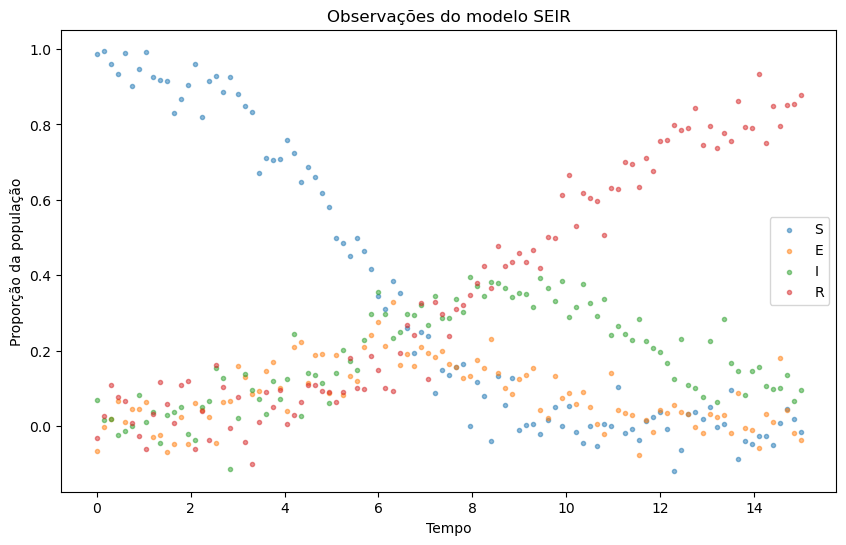

In [11]:
# Gerando dados sintéticos
np.random.seed(19920908)
Y0 = np.concatenate([np.array([0.97, 0.0, 0.01, 0.0]), np.zeros(12)])  # 12 para sensitividades (4x3)
t_span = (0, 15)
t_eval = np.linspace(*t_span, 101)
true_theta, true_sigma, true_gamma = 2.0, 0.8, 0.3

sol = solve_ivp(
    lambda t, y: ODESYS(y, t, true_theta, true_sigma, true_gamma),
    t_span, Y0, t_eval=t_eval, method='RK45'
)

y_obs = sol.y[:4].T + np.random.normal(0, 0.05, size=sol.y[:4].T.shape)
# Plot observações
plt.figure(figsize=(10, 6))
plt.scatter(t_eval, y_obs[:, 0], marker=".", alpha=0.5, label="S")
plt.scatter(t_eval, y_obs[:, 1], marker=".", alpha=0.5, label="E")
plt.scatter(t_eval, y_obs[:, 2], marker=".", alpha=0.5, label="I")
plt.scatter(t_eval, y_obs[:, 3], marker=".", alpha=0.5, label="R")
plt.legend()
plt.title("Observações do modelo SEIR")
plt.xlabel("Tempo")
plt.ylabel("Proporção da população")
plt.show()

In [12]:
# Gradiente descendente com busca linear
theta, sigma, gamma = 1.5, 1.0, 0.1  # Chute inicial

print(f"Valores verdadeiros: θ0={true_theta:.4f}, σ={true_sigma:.4f}, gamma={true_gamma:.4f}")
print(f"Chute inicial:       θ0={theta:.4f}, σ={sigma:.4f}, gamma={gamma:.4f}")

cost = Cost(y_obs)
grad_c = autograd.grad(cost)

maxiter = 100
prev_cost = 1
tolerance = 1e-6
error_history = []
par_history = []
alpha_history = []

def line_search(theta, sigma, gamma, grad, sensitivities, Y, current_cost):
    alpha = 1.0
    beta = 0.2
    c = 1e-4
    new_cost = 2*current_cost

    s = c / np.linalg.norm(grad(Y))**2
    new_sensitivities = sensitivities

    while (new_cost > current_cost) and (s > 1e-10):
        s *= beta

        new_theta = theta - s * (grad(Y) * new_sensitivities[:, :, 0]).sum()
        new_sigma  = sigma  - s * (grad(Y) * new_sensitivities[:, :, 1]).sum()
        new_gamma  = gamma  - s * (grad(Y) * new_sensitivities[:, :, 2]).sum()

        sol = solve_ivp(
            lambda t, y: ODESYS(y, t, new_theta, new_sigma, new_gamma),
            t_span, Y0, t_eval=t_eval, method='RK45'
        )
        Y_new = sol.y[:4].T
        new_cost = cost(Y_new)
        new_sensitivities = sol.y[4:].T.reshape(-1, 4, 3)

    new_new_theta = new_theta - s * (grad(Y_new) * new_sensitivities[:, :, 0]).sum()
    new_new_sigma = new_sigma - s * (grad(Y_new) * new_sensitivities[:, :, 1]).sum()
    new_new_gamma = new_gamma - s * (grad(Y_new) * new_sensitivities[:, :, 2]).sum()

    sol = solve_ivp(
        lambda t, y: ODESYS(y, t, new_new_theta, new_new_sigma, new_new_gamma),
        t_span, Y0, t_eval=t_eval, method='RK45'
    )
    Y_new_new = sol.y[:4].T
    new_new_cost = cost(Y_new_new)

    div1 = (new_cost - current_cost) / s
    div2 = (new_new_cost -2*new_cost + current_cost)/(2*s*s)
    alpha = 0.5 * (s - div1/div2)
    
    if alpha < 0:
        alpha = s

    return alpha

for i in range(maxiter):
    sol = solve_ivp(
        lambda t, y: ODESYS(y, t, theta, sigma, gamma),
        t_span, Y0, t_eval=t_eval, method='RK45'
    )
    Y = sol.y[:4].T

    sensitivities = sol.y[4:].T.reshape(-1, 4, 3)

    current_cost = cost(Y)

    error_history.append(current_cost)
    par_history.append((theta, sigma, gamma))
    alpha_history.append(0.0)

    if abs((current_cost - prev_cost)/prev_cost) < tolerance and i > 0:
        print(f"Convergiu na iteração {i}")
        break

    prev_cost = current_cost

    alpha = line_search(theta, sigma, gamma, grad_c, sensitivities, Y, current_cost)

    theta -= alpha * (grad_c(Y) * sensitivities[:, :, 0]).sum()
    sigma  -= alpha * (grad_c(Y) * sensitivities[:, :, 1]).sum()
    gamma  -= alpha * (grad_c(Y) * sensitivities[:, :, 2]).sum()

    if i % 5 == 0:
        print(f"Iter {i}: theta={theta:.4f}, sigma={sigma:.4f}, gamma={gamma:.4f}, alpha={alpha:.4f}, current_cost={current_cost:.4f}")


Valores verdadeiros: θ0=2.0000, σ=0.8000, gamma=0.3000
Chute inicial:       θ0=1.5000, σ=1.0000, gamma=0.1000
Iter 0: theta=1.5002, sigma=1.0001, gamma=0.1130, alpha=0.6963, current_cost=0.0028
Iter 5: theta=1.7115, sigma=1.0833, gamma=0.5685, alpha=69.2906, current_cost=0.0011
Iter 10: theta=1.7787, sigma=1.0264, gamma=0.2720, alpha=33.8435, current_cost=0.0010
Iter 15: theta=1.7987, sigma=0.9949, gamma=0.3642, alpha=38.3524, current_cost=0.0010
Iter 20: theta=1.8418, sigma=0.9794, gamma=0.2704, alpha=31.6296, current_cost=0.0011
Iter 25: theta=1.8430, sigma=0.9392, gamma=0.3703, alpha=38.0286, current_cost=0.0010


KeyboardInterrupt: 

In [ ]:
print("\n" + "-" * 80)
print("RESULTADOS FINAIS:")
print(f"Valores verdadeiros: θ={true_theta:.4f}, σ={true_sigma:.4f}, gamma={true_gamma:.4f}")
print(f"Valores estimados:   θ={theta:.4f}, σ={sigma:.4f}, gamma={gamma:.4f}")
print(f"Erro θ: {abs(theta - true_theta)/true_theta*100:.2f}%")
print(f"Erro σ: {abs(sigma - true_sigma)/true_sigma*100:.2f}%")
print(f"Erro gamma: {abs(gamma - true_gamma)/true_gamma*100:.2f}%")
print(f"Custo final: {current_cost:.6f}")


--------------------------------------------------------------------------------
RESULTADOS FINAIS:
Valores verdadeiros: θ=2.0000, σ=0.8000, gamma=0.3000
Valores estimados:   θ=2.0171, σ=0.7799, gamma=0.3541
Erro θ: 0.85%
Erro σ: 2.51%
Erro gamma: 18.03%
Custo final: 0.000972


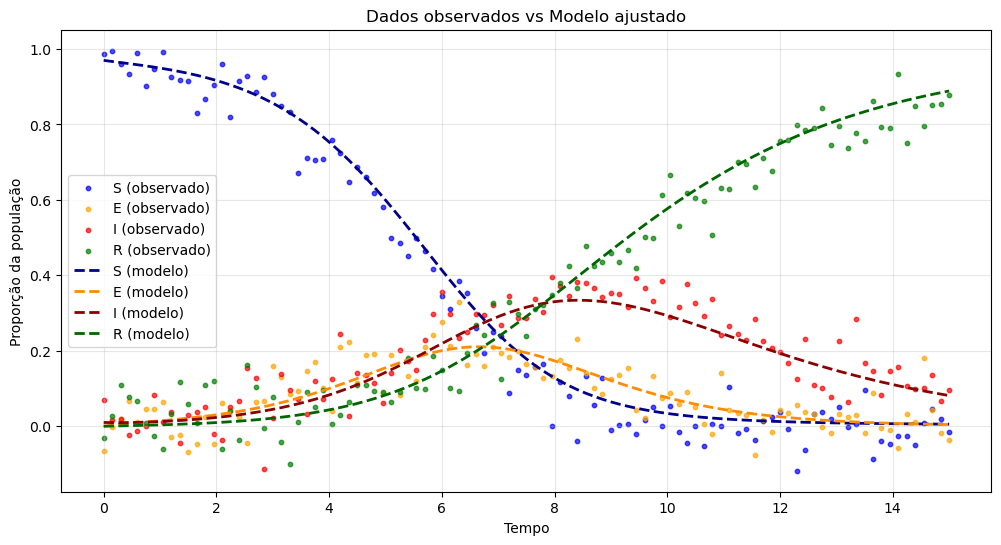

In [ ]:
# Plot dos dados observados vs modelo final
sol_final = solve_ivp(
    lambda t, y: ODESYS(y, t, theta, sigma, gamma),
    t_span, Y0, t_eval=t_eval, method='RK45'
)
y_final = sol_final.y[:4].T

plt.figure(figsize=(12, 6))

plt.scatter(t_eval, y_obs[:, 0], alpha=0.7, label='S (observado)', color='blue', s=10)
plt.scatter(t_eval, y_obs[:, 1], alpha=0.7, label='E (observado)', color='orange', s=10)
plt.scatter(t_eval, y_obs[:, 2], alpha=0.7, label='I (observado)', color='red', s=10)
plt.scatter(t_eval, y_obs[:, 3], alpha=0.7, label='R (observado)', color='green', s=10)

plt.plot(t_eval, y_final[:, 0], '--', label='S (modelo)', color='darkblue', linewidth=2)
plt.plot(t_eval, y_final[:, 1], '--', label='E (modelo)', color='darkorange', linewidth=2)
plt.plot(t_eval, y_final[:, 2], '--', label='I (modelo)', color='darkred', linewidth=2)
plt.plot(t_eval, y_final[:, 3], '--', label='R (modelo)', color='darkgreen', linewidth=2)

plt.xlabel('Tempo')
plt.ylabel('Proporção da população')
plt.title('Dados observados vs Modelo ajustado')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


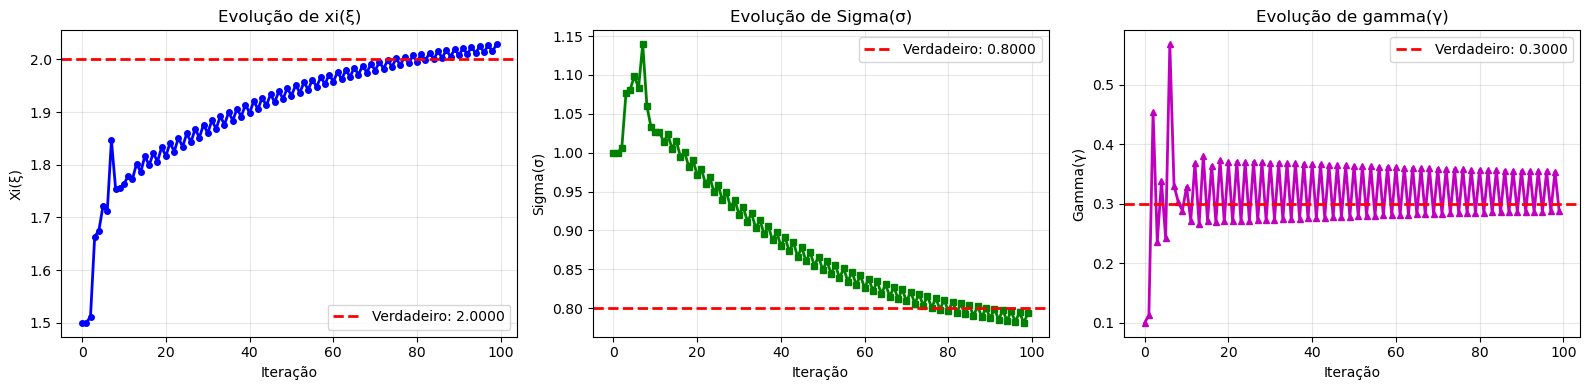

In [ ]:
# Plot da evolução dos parâmetros durante a otimização
par_history = np.array(par_history)

plt.figure(figsize=(16, 4))

# Subplot 1: xi (antigo theta)
plt.subplot(1, 3, 1)
plt.plot(par_history[:, 0], 'b-', linewidth=2, marker='o', markersize=4)
plt.axhline(y=true_theta, color='r', linestyle='--', linewidth=2, label=f'Verdadeiro: {true_theta:.4f}')
plt.xlabel('Iteração')
plt.ylabel('Xi(ξ)')
plt.title('Evolução de xi(ξ)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: sigma
plt.subplot(1, 3, 2)
plt.plot(par_history[:, 1], 'g-', linewidth=2, marker='s', markersize=4)
plt.axhline(y=true_sigma, color='r', linestyle='--', linewidth=2, label=f'Verdadeiro: {true_sigma:.4f}')
plt.xlabel('Iteração')
plt.ylabel('Sigma(σ)')
plt.title('Evolução de Sigma(σ)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: gamma
plt.subplot(1, 3, 3)
plt.plot(par_history[:, 2], 'm-', linewidth=2, marker='^', markersize=4)
plt.axhline(y=true_gamma, color='r', linestyle='--', linewidth=2, label=f'Verdadeiro: {true_gamma:.4f}')
plt.xlabel('Iteração')
plt.ylabel('Gamma(γ)')
plt.title('Evolução de gamma(γ)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
